## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


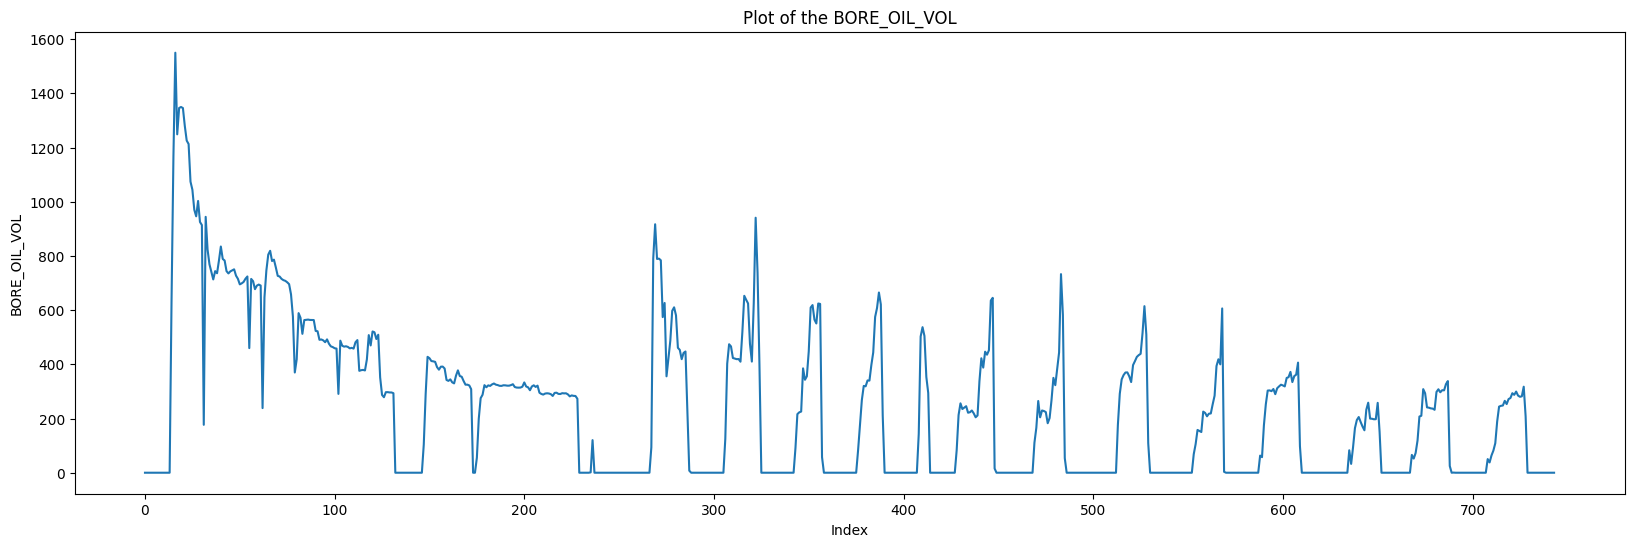

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


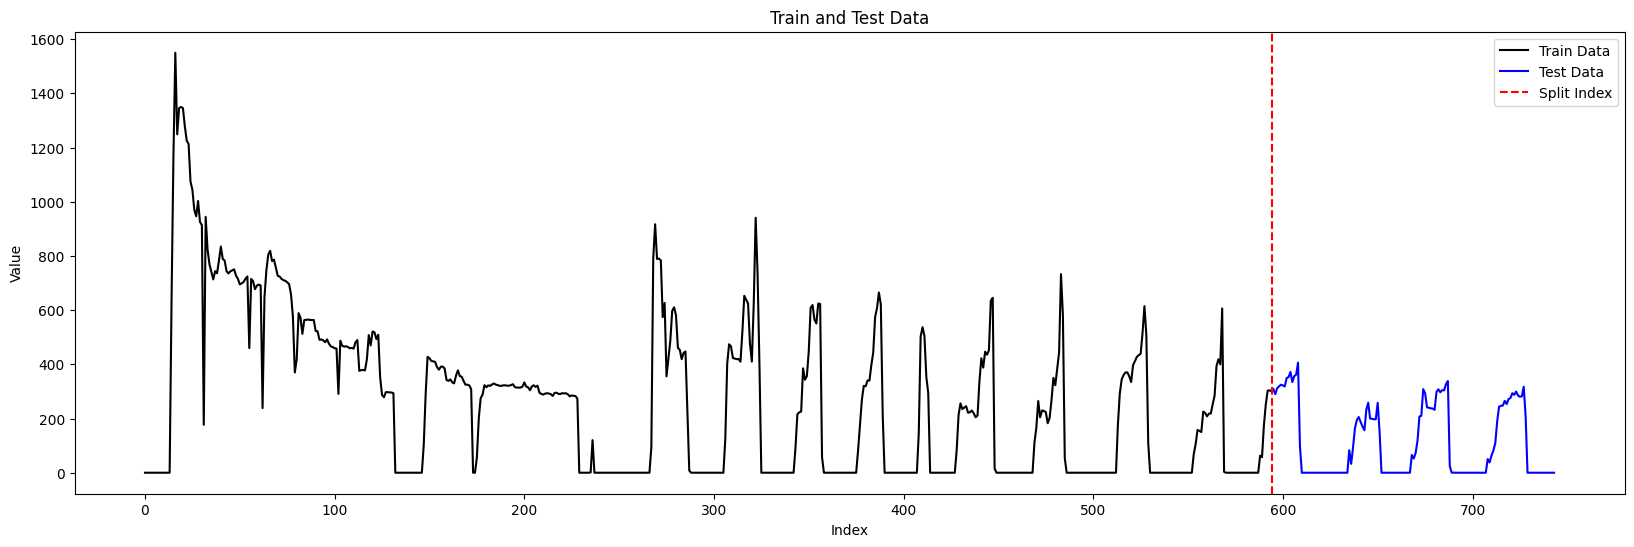

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 1000 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('window_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    Dropout_rate = trial.suggest_float('Dropout_rate', 0.1, 0.5)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
        model_LSTM.add(Dropout(Dropout_rate))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-10-26 09:45:34,144] A new study created in memory with name: no-name-576f0780-02b8-4898-86c5-2b45f248e43c


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a029363f-5c47-41b4-a280-aea9df61b31b/assets


INFO:tensorflow:Assets written to: ram://a029363f-5c47-41b4-a280-aea9df61b31b/assets
[I 2023-10-26 10:06:31,397] Trial 0 finished with value: 0.012033136561512947 and parameters: {'window_size': 41, 'n_lstm_layers': 17, 'lstm_units': 237, 'learning_rate': 0.005370656799800972, 'Dropout_rate': 0.2650709578881727}. Best is trial 0 with value: 0.012033136561512947.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://e6a1c3db-3e2d-4fba-88f8-c57e65093197/assets


INFO:tensorflow:Assets written to: ram://e6a1c3db-3e2d-4fba-88f8-c57e65093197/assets
[I 2023-10-26 10:12:38,732] Trial 1 finished with value: 0.016098324209451675 and parameters: {'window_size': 40, 'n_lstm_layers': 5, 'lstm_units': 100, 'learning_rate': 0.000880039401559349, 'Dropout_rate': 0.34992480187675634}. Best is trial 0 with value: 0.012033136561512947.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://9234b51e-d135-4e30-8788-126a680997f7/assets


INFO:tensorflow:Assets written to: ram://9234b51e-d135-4e30-8788-126a680997f7/assets
[I 2023-10-26 10:26:26,593] Trial 2 finished with value: 0.016613012179732323 and parameters: {'window_size': 23, 'n_lstm_layers': 8, 'lstm_units': 207, 'learning_rate': 0.008345077380317305, 'Dropout_rate': 0.49727829715389893}. Best is trial 0 with value: 0.012033136561512947.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://0235dc16-538c-4de4-b287-2f5c85cf028a/assets


INFO:tensorflow:Assets written to: ram://0235dc16-538c-4de4-b287-2f5c85cf028a/assets
[I 2023-10-26 10:42:09,198] Trial 3 finished with value: 0.016467992216348648 and parameters: {'window_size': 40, 'n_lstm_layers': 12, 'lstm_units': 138, 'learning_rate': 0.003482379171892496, 'Dropout_rate': 0.48453893559243433}. Best is trial 0 with value: 0.012033136561512947.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://50fda7ef-a54b-4c27-b06a-ce700dca0542/assets


INFO:tensorflow:Assets written to: ram://50fda7ef-a54b-4c27-b06a-ce700dca0542/assets
[I 2023-10-26 11:30:32,041] Trial 4 finished with value: 0.03101527877151966 and parameters: {'window_size': 6, 'n_lstm_layers': 16, 'lstm_units': 48, 'learning_rate': 0.006911255354020627, 'Dropout_rate': 0.4194864919143445}. Best is trial 0 with value: 0.012033136561512947.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 11:30:59,744] Trial 5 pruned. 
[I 2023-10-26 11:31:27,173] Trial 6 pruned. 


INFO:tensorflow:Assets written to: ram://6059d4f9-4f92-4a71-959a-6592d5ef87e4/assets


INFO:tensorflow:Assets written to: ram://6059d4f9-4f92-4a71-959a-6592d5ef87e4/assets
[I 2023-10-26 11:42:21,098] Trial 7 finished with value: 0.008773315697908401 and parameters: {'window_size': 47, 'n_lstm_layers': 12, 'lstm_units': 55, 'learning_rate': 0.0031808351890008336, 'Dropout_rate': 0.32349537677805384}. Best is trial 7 with value: 0.008773315697908401.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 11:43:01,275] Trial 8 pruned. 
[I 2023-10-26 11:43:39,314] Trial 9 pruned. 


INFO:tensorflow:Assets written to: ram://93e5c6ba-ef36-4c53-88cc-9f844a683663/assets


INFO:tensorflow:Assets written to: ram://93e5c6ba-ef36-4c53-88cc-9f844a683663/assets
[I 2023-10-26 11:45:56,863] Trial 10 finished with value: 0.024803539738059044 and parameters: {'window_size': 58, 'n_lstm_layers': 1, 'lstm_units': 35, 'learning_rate': 0.0017865807275718494, 'Dropout_rate': 0.18510301103451804}. Best is trial 7 with value: 0.008773315697908401.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 11:46:34,741] Trial 11 pruned. 
[I 2023-10-26 11:47:18,786] Trial 12 pruned. 
[I 2023-10-26 11:47:

INFO:tensorflow:Assets written to: ram://d094fabd-00a4-438e-9449-d17ffd2388cb/assets


INFO:tensorflow:Assets written to: ram://d094fabd-00a4-438e-9449-d17ffd2388cb/assets
[I 2023-10-26 11:54:33,453] Trial 15 finished with value: 0.0026204404421150684 and parameters: {'window_size': 50, 'n_lstm_layers': 6, 'lstm_units': 97, 'learning_rate': 0.0026319569962172705, 'Dropout_rate': 0.22665261439064255}. Best is trial 15 with value: 0.0026204404421150684.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://8986aa25-045d-4c2b-8a1a-73fb13bc7773/assets


INFO:tensorflow:Assets written to: ram://8986aa25-045d-4c2b-8a1a-73fb13bc7773/assets
[I 2023-10-26 12:00:00,358] Trial 16 finished with value: 0.006965826265513897 and parameters: {'window_size': 50, 'n_lstm_layers': 5, 'lstm_units': 78, 'learning_rate': 0.0023413347110618704, 'Dropout_rate': 0.20228026338004745}. Best is trial 15 with value: 0.0026204404421150684.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://6d5c2636-a04c-48a2-bd8e-6ca796507f95/assets


INFO:tensorflow:Assets written to: ram://6d5c2636-a04c-48a2-bd8e-6ca796507f95/assets
[I 2023-10-26 12:05:44,703] Trial 17 finished with value: 0.011071937158703804 and parameters: {'window_size': 53, 'n_lstm_layers': 5, 'lstm_units': 91, 'learning_rate': 0.0020895957156804213, 'Dropout_rate': 0.209312891159824}. Best is trial 15 with value: 0.0026204404421150684.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://46d19175-8caa-48d7-910e-c11f3a22c087/assets


INFO:tensorflow:Assets written to: ram://46d19175-8caa-48d7-910e-c11f3a22c087/assets
[I 2023-10-26 12:10:55,824] Trial 18 finished with value: 0.0022237072698771954 and parameters: {'window_size': 19, 'n_lstm_layers': 2, 'lstm_units': 116, 'learning_rate': 0.001831166000305519, 'Dropout_rate': 0.16147010326848257}. Best is trial 18 with value: 0.0022237072698771954.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://b2320e15-b30a-49aa-9df1-0aa3e3b66bf8/assets


INFO:tensorflow:Assets written to: ram://b2320e15-b30a-49aa-9df1-0aa3e3b66bf8/assets
[I 2023-10-26 12:14:52,806] Trial 19 finished with value: 0.0019428494852036238 and parameters: {'window_size': 19, 'n_lstm_layers': 1, 'lstm_units': 121, 'learning_rate': 0.0014823489013887623, 'Dropout_rate': 0.14205141077043099}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:14:58,514] Trial 20 pruned. 


INFO:tensorflow:Assets written to: ram://36592d39-7b51-412c-a643-c540ae9f2146/assets


INFO:tensorflow:Assets written to: ram://36592d39-7b51-412c-a643-c540ae9f2146/assets
[I 2023-10-26 12:20:15,419] Trial 21 finished with value: 0.002013511722907424 and parameters: {'window_size': 18, 'n_lstm_layers': 2, 'lstm_units': 120, 'learning_rate': 0.0016050152182444785, 'Dropout_rate': 0.1577848263963342}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:20:22,954] Trial 22 pruned. 
[I 2023-10-26 12:20:31,088] Trial 23 pruned. 


INFO:tensorflow:Assets written to: ram://a17972a9-73f1-475c-aef0-208704b15303/assets


INFO:tensorflow:Assets written to: ram://a17972a9-73f1-475c-aef0-208704b15303/assets
[I 2023-10-26 12:26:20,014] Trial 24 finished with value: 0.0025700253900140524 and parameters: {'window_size': 11, 'n_lstm_layers': 1, 'lstm_units': 114, 'learning_rate': 0.0015480869031797013, 'Dropout_rate': 0.15042673445145618}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:26:27,653] Trial 25 pruned. 
[I 2023-10-26 12:26:41,120] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://f4cc9b51-2baf-4f87-ac99-314ef9cb1ae3/assets


INFO:tensorflow:Assets written to: ram://f4cc9b51-2baf-4f87-ac99-314ef9cb1ae3/assets
[I 2023-10-26 12:31:14,734] Trial 27 finished with value: 0.0021844925358891487 and parameters: {'window_size': 21, 'n_lstm_layers': 1, 'lstm_units': 174, 'learning_rate': 0.0024841944518226035, 'Dropout_rate': 0.13769054581907417}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://0c7d2d4e-7a26-42e3-8fd2-849c56d8a972/assets


INFO:tensorflow:Assets written to: ram://0c7d2d4e-7a26-42e3-8fd2-849c56d8a972/assets
[I 2023-10-26 12:36:46,369] Trial 28 finished with value: 0.001978861400857568 and parameters: {'window_size': 12, 'n_lstm_layers': 1, 'lstm_units': 175, 'learning_rate': 0.002785992736645916, 'Dropout_rate': 0.1323934453169647}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:37:01,800] Trial 29 pruned. 
[I 2023-10-26 12:37:12,064] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://255c3351-eb04-4b37-a113-012afdad49fa/assets


INFO:tensorflow:Assets written to: ram://255c3351-eb04-4b37-a113-012afdad49fa/assets
[I 2023-10-26 12:41:27,529] Trial 31 finished with value: 0.0028454880230128765 and parameters: {'window_size': 21, 'n_lstm_layers': 1, 'lstm_units': 173, 'learning_rate': 0.002491259947009959, 'Dropout_rate': 0.14017875346538627}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://50333cc1-3cce-4f30-be2b-c7c8e9d7913c/assets


INFO:tensorflow:Assets written to: ram://50333cc1-3cce-4f30-be2b-c7c8e9d7913c/assets
[I 2023-10-26 12:48:33,168] Trial 32 finished with value: 0.002624912653118372 and parameters: {'window_size': 14, 'n_lstm_layers': 2, 'lstm_units': 204, 'learning_rate': 0.0024250135880137177, 'Dropout_rate': 0.13959608368770426}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:48:43,888] Trial 33 pruned. 


INFO:tensorflow:Assets written to: ram://3cab8ae7-1f52-4004-8f04-38ee8be3638f/assets


INFO:tensorflow:Assets written to: ram://3cab8ae7-1f52-4004-8f04-38ee8be3638f/assets
[I 2023-10-26 12:52:43,126] Trial 34 finished with value: 0.00451479759067297 and parameters: {'window_size': 26, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.00156298449836841, 'Dropout_rate': 0.10330817630319569}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 12:53:02,627] Trial 35 pruned. 
[I 2023-10-26 12:53:12,539] Trial 36 pruned. 
[I 2023-10-26 12:53:

INFO:tensorflow:Assets written to: ram://6094b2c9-169e-4a8b-afb1-0ba96cc43902/assets


INFO:tensorflow:Assets written to: ram://6094b2c9-169e-4a8b-afb1-0ba96cc43902/assets
[I 2023-10-26 13:35:28,797] Trial 38 finished with value: 0.0024082516320049763 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 187, 'learning_rate': 0.001250612706324668, 'Dropout_rate': 0.14900560304561125}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 13:35:40,285] Trial 39 pruned. 
[I 2023-10-26 13:35:55,371] Trial 40 pruned. 
[I 2023-10-26 13:3

INFO:tensorflow:Assets written to: ram://d39a5be1-f75d-43c6-b16c-05e36e1a989a/assets


INFO:tensorflow:Assets written to: ram://d39a5be1-f75d-43c6-b16c-05e36e1a989a/assets
[I 2023-10-26 13:39:31,989] Trial 42 finished with value: 0.004171784035861492 and parameters: {'window_size': 24, 'n_lstm_layers': 1, 'lstm_units': 106, 'learning_rate': 0.0015128130014525221, 'Dropout_rate': 0.18968466209798443}. Best is trial 19 with value: 0.0019428494852036238.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 13:39:38,486] Trial 43 pruned. 
[I 2023-10-26 13:39:48,812] Trial 44 pruned. 


INFO:tensorflow:Assets written to: ram://bbaf212e-cf73-4fb7-a9f7-fed4a02e55f5/assets


INFO:tensorflow:Assets written to: ram://bbaf212e-cf73-4fb7-a9f7-fed4a02e55f5/assets
[I 2023-10-26 13:42:38,279] Trial 45 finished with value: 0.001739045255817473 and parameters: {'window_size': 36, 'n_lstm_layers': 1, 'lstm_units': 89, 'learning_rate': 0.0035936944490178456, 'Dropout_rate': 0.14962480257955119}. Best is trial 45 with value: 0.001739045255817473.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://004da3ad-d1bf-4011-a356-6b08414e5cdf/assets


INFO:tensorflow:Assets written to: ram://004da3ad-d1bf-4011-a356-6b08414e5cdf/assets
[I 2023-10-26 13:45:28,050] Trial 46 finished with value: 0.004714843817055225 and parameters: {'window_size': 37, 'n_lstm_layers': 1, 'lstm_units': 87, 'learning_rate': 0.0034613937374396225, 'Dropout_rate': 0.13949389500578907}. Best is trial 45 with value: 0.001739045255817473.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 13:45:35,804] Trial 47 pruned. 
[I 2023-10-26 13:45:58,095] Trial 48 pruned. 


INFO:tensorflow:Assets written to: ram://9bdbd0db-8df0-4297-95eb-a6887037a967/assets


INFO:tensorflow:Assets written to: ram://9bdbd0db-8df0-4297-95eb-a6887037a967/assets
[I 2023-10-26 13:49:42,598] Trial 49 finished with value: 0.005610541440546513 and parameters: {'window_size': 28, 'n_lstm_layers': 1, 'lstm_units': 177, 'learning_rate': 0.003522330259434449, 'Dropout_rate': 0.11889796547574491}. Best is trial 45 with value: 0.001739045255817473.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 13:49:51,336] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://6f1de001-84db-48ff-a51e-6ac02589cc72/assets


INFO:tensorflow:Assets written to: ram://6f1de001-84db-48ff-a51e-6ac02589cc72/assets
[I 2023-10-26 13:55:06,652] Trial 51 finished with value: 0.0022148173302412033 and parameters: {'window_size': 19, 'n_lstm_layers': 2, 'lstm_units': 124, 'learning_rate': 0.0017536254250293487, 'Dropout_rate': 0.1598366910655634}. Best is trial 45 with value: 0.001739045255817473.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 13:55:12,059] Trial 52 pruned. 
[I 2023-10-26 13:55:18,325] Trial 53 pruned. 
[I 2023-10-26 13:5

INFO:tensorflow:Assets written to: ram://63d3d25e-8a33-4243-878c-8d3f6848dce1/assets


INFO:tensorflow:Assets written to: ram://63d3d25e-8a33-4243-878c-8d3f6848dce1/assets
[I 2023-10-26 14:01:17,644] Trial 60 finished with value: 0.0020858272910118103 and parameters: {'window_size': 16, 'n_lstm_layers': 1, 'lstm_units': 195, 'learning_rate': 0.0017424014841647861, 'Dropout_rate': 0.1922955877871093}. Best is trial 45 with value: 0.001739045255817473.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://6e98f95f-95a3-409b-876f-939523c95914/assets


INFO:tensorflow:Assets written to: ram://6e98f95f-95a3-409b-876f-939523c95914/assets
[I 2023-10-26 14:05:52,887] Trial 61 finished with value: 0.0017094172071665525 and parameters: {'window_size': 19, 'n_lstm_layers': 1, 'lstm_units': 235, 'learning_rate': 0.0015105814123388649, 'Dropout_rate': 0.17238928919214438}. Best is trial 61 with value: 0.0017094172071665525.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://e9f053c9-c676-406f-ae50-4a261276ddc6/assets


INFO:tensorflow:Assets written to: ram://e9f053c9-c676-406f-ae50-4a261276ddc6/assets
[I 2023-10-26 14:10:02,502] Trial 62 finished with value: 0.00206848606467247 and parameters: {'window_size': 16, 'n_lstm_layers': 1, 'lstm_units': 224, 'learning_rate': 0.0013869626128745456, 'Dropout_rate': 0.1967461605521773}. Best is trial 61 with value: 0.0017094172071665525.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:10:06,871] Trial 63 pruned. 
[I 2023-10-26 14:10:13,998] Trial 64 pruned. 
[I 2023-10-26 14:10

INFO:tensorflow:Assets written to: ram://dce0f9d9-6b62-4530-997b-d5ac578641cb/assets


INFO:tensorflow:Assets written to: ram://dce0f9d9-6b62-4530-997b-d5ac578641cb/assets
[I 2023-10-26 14:15:17,184] Trial 67 finished with value: 0.002103805774822831 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.001661997515760006, 'Dropout_rate': 0.1729493982281801}. Best is trial 61 with value: 0.0017094172071665525.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:15:23,034] Trial 68 pruned. 
[I 2023-10-26 14:15:37,033] Trial 69 pruned. 
[I 2023-10-26 14:15

INFO:tensorflow:Assets written to: ram://c50ca1f7-e0b2-4142-b02c-42e389774c47/assets


INFO:tensorflow:Assets written to: ram://c50ca1f7-e0b2-4142-b02c-42e389774c47/assets
[I 2023-10-26 14:20:36,391] Trial 71 finished with value: 0.0022425695788115263 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.0016933371739786215, 'Dropout_rate': 0.173868709045474}. Best is trial 61 with value: 0.0017094172071665525.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:20:40,581] Trial 72 pruned. 
[I 2023-10-26 14:20:46,731] Trial 73 pruned. 


INFO:tensorflow:Assets written to: ram://fab27e0e-6932-434c-a9a4-0938ae248ffd/assets


INFO:tensorflow:Assets written to: ram://fab27e0e-6932-434c-a9a4-0938ae248ffd/assets
[I 2023-10-26 14:25:05,703] Trial 74 finished with value: 0.0018135533900931478 and parameters: {'window_size': 16, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.0016095869393808434, 'Dropout_rate': 0.1858542507307657}. Best is trial 61 with value: 0.0017094172071665525.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:25:11,291] Trial 75 pruned. 
[I 2023-10-26 14:25:20,853] Trial 76 pruned. 
[I 2023-10-26 14:

INFO:tensorflow:Assets written to: ram://47e30505-23ba-499c-a875-9003893ab5ae/assets


INFO:tensorflow:Assets written to: ram://47e30505-23ba-499c-a875-9003893ab5ae/assets
[I 2023-10-26 14:30:30,639] Trial 81 finished with value: 0.0016013327986001968 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.0016742249097132028, 'Dropout_rate': 0.16648088553762358}. Best is trial 81 with value: 0.0016013327986001968.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:30:34,516] Trial 82 pruned. 


INFO:tensorflow:Assets written to: ram://0b4dc7a9-fc6a-42dc-b933-39708f1ba2a7/assets


INFO:tensorflow:Assets written to: ram://0b4dc7a9-fc6a-42dc-b933-39708f1ba2a7/assets
[I 2023-10-26 14:35:36,582] Trial 83 finished with value: 0.0014572897925972939 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0011285726903793745, 'Dropout_rate': 0.18399254774066162}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:35:42,743] Trial 84 pruned. 
[I 2023-10-26 14:35:47,406] Trial 85 pruned. 
[I 2023-10-26 14

INFO:tensorflow:Assets written to: ram://22de9944-5d5c-4f56-b1c4-ab55dd093542/assets


INFO:tensorflow:Assets written to: ram://22de9944-5d5c-4f56-b1c4-ab55dd093542/assets
[I 2023-10-26 14:41:38,883] Trial 91 finished with value: 0.0018294623587280512 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.001689363111241262, 'Dropout_rate': 0.18911450716172334}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:41:45,052] Trial 92 pruned. 


INFO:tensorflow:Assets written to: ram://b9f80e2a-685d-4d8b-aee1-2e30fdb10b2c/assets


INFO:tensorflow:Assets written to: ram://b9f80e2a-685d-4d8b-aee1-2e30fdb10b2c/assets
[I 2023-10-26 14:47:17,012] Trial 93 finished with value: 0.0021828417666256428 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.002059077192234104, 'Dropout_rate': 0.20192790241098496}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://54bf7a7d-babb-439c-830e-2c6da5521d62/assets


INFO:tensorflow:Assets written to: ram://54bf7a7d-babb-439c-830e-2c6da5521d62/assets
[I 2023-10-26 14:52:01,207] Trial 94 finished with value: 0.0019520733039826155 and parameters: {'window_size': 19, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.0015726853258399445, 'Dropout_rate': 0.16766449191367747}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:52:32,140] Trial 95 pruned. 
[I 2023-10-26 14:53:01,448] Trial 96 pruned. 
[I 2023-10-26 14

INFO:tensorflow:Assets written to: ram://6c8ec624-ca7a-47f8-92f9-f2e232223e02/assets


INFO:tensorflow:Assets written to: ram://6c8ec624-ca7a-47f8-92f9-f2e232223e02/assets
[I 2023-10-26 14:59:30,735] Trial 107 finished with value: 0.0018644254887476563 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 235, 'learning_rate': 0.0013514222410292744, 'Dropout_rate': 0.1760996790562851}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 14:59:36,637] Trial 108 pruned. 
[I 2023-10-26 14:59:44,139] Trial 109 pruned. 


INFO:tensorflow:Assets written to: ram://f716c240-c37d-4db8-acac-8636b504171f/assets


INFO:tensorflow:Assets written to: ram://f716c240-c37d-4db8-acac-8636b504171f/assets
[I 2023-10-26 15:04:20,247] Trial 110 finished with value: 0.0022077704779803753 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 236, 'learning_rate': 0.0026985734336917844, 'Dropout_rate': 0.10860031993264402}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:04:24,156] Trial 111 pruned. 


INFO:tensorflow:Assets written to: ram://61322274-4688-40f3-ba1a-3a28effe1798/assets


INFO:tensorflow:Assets written to: ram://61322274-4688-40f3-ba1a-3a28effe1798/assets
[I 2023-10-26 15:09:26,366] Trial 112 finished with value: 0.0020108958706259727 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.0014268178770818847, 'Dropout_rate': 0.19603344819377624}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:09:32,758] Trial 113 pruned. 
[I 2023-10-26 15:09:39,932] Trial 114 pruned. 


INFO:tensorflow:Assets written to: ram://eca7b467-1cf7-4e58-a5ac-16ba28bebbb7/assets


INFO:tensorflow:Assets written to: ram://eca7b467-1cf7-4e58-a5ac-16ba28bebbb7/assets
[I 2023-10-26 15:13:55,645] Trial 115 finished with value: 0.002431174973025918 and parameters: {'window_size': 21, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.0015315492981438769, 'Dropout_rate': 0.1458121562479079}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:13:59,836] Trial 116 pruned. 
[I 2023-10-26 15:14:07,259] Trial 117 pruned. 


INFO:tensorflow:Assets written to: ram://9dcb00cc-5ff9-4706-bdfe-e8732e53491e/assets


INFO:tensorflow:Assets written to: ram://9dcb00cc-5ff9-4706-bdfe-e8732e53491e/assets
[I 2023-10-26 15:18:59,962] Trial 118 finished with value: 0.002255452796816826 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 238, 'learning_rate': 0.001971702879302612, 'Dropout_rate': 0.21740972617980986}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:19:06,298] Trial 119 pruned. 
[I 2023-10-26 15:19:12,814] Trial 120 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://db3f2092-59f3-4013-b6a1-da1d7feaaef8/assets


INFO:tensorflow:Assets written to: ram://db3f2092-59f3-4013-b6a1-da1d7feaaef8/assets
[I 2023-10-26 15:24:44,123] Trial 127 finished with value: 0.0015920618316158652 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.0017182069511010342, 'Dropout_rate': 0.18095208796271092}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:24:50,560] Trial 128 pruned. 
[I 2023-10-26 15:24:59,570] Trial 129 pruned. 
[I 2023-10-26

INFO:tensorflow:Assets written to: ram://08445c43-ef22-4b8b-bd27-3d4fc4ed4b9b/assets


INFO:tensorflow:Assets written to: ram://08445c43-ef22-4b8b-bd27-3d4fc4ed4b9b/assets
[I 2023-10-26 15:32:40,355] Trial 152 finished with value: 0.0020658299326896667 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.001410384778355085, 'Dropout_rate': 0.1613114046944005}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 15:32:44,995] Trial 153 pruned. 
[I 2023-10-26 15:32:49,316] Trial 154 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://72f62865-9959-4503-a641-89d777c246a4/assets


INFO:tensorflow:Assets written to: ram://72f62865-9959-4503-a641-89d777c246a4/assets
[I 2023-10-26 15:38:58,166] Trial 161 finished with value: 0.0019335816614329815 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0015997179606881187, 'Dropout_rate': 0.18446282757947405}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://0ebf2025-3da8-4e81-9da9-50914679d843/assets


INFO:tensorflow:Assets written to: ram://0ebf2025-3da8-4e81-9da9-50914679d843/assets
[I 2023-10-26 15:44:01,034] Trial 162 finished with value: 0.00192332046572119 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0015995976468490426, 'Dropout_rate': 0.18106142669536643}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://2806758e-a1dc-4a48-9141-b43ce60ba1b7/assets


INFO:tensorflow:Assets written to: ram://2806758e-a1dc-4a48-9141-b43ce60ba1b7/assets
[I 2023-10-26 15:49:05,193] Trial 163 finished with value: 0.0019798048306256533 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0014979376061519303, 'Dropout_rate': 0.18302128785867075}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://e4c8d9a9-632b-40cd-8ad9-cb4ad99a116c/assets


INFO:tensorflow:Assets written to: ram://e4c8d9a9-632b-40cd-8ad9-cb4ad99a116c/assets
[I 2023-10-26 15:54:08,177] Trial 164 finished with value: 0.0017340837512165308 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0015130932831010412, 'Dropout_rate': 0.18270313306184893}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a8102fe6-05cb-490f-9bda-843b8fee85c9/assets


INFO:tensorflow:Assets written to: ram://a8102fe6-05cb-490f-9bda-843b8fee85c9/assets
[I 2023-10-26 15:58:11,552] Trial 165 finished with value: 0.0021711511071771383 and parameters: {'window_size': 20, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0019308173602026132, 'Dropout_rate': 0.18036775527411636}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://849c2f96-0a56-4b7f-973c-94ab24612585/assets


INFO:tensorflow:Assets written to: ram://849c2f96-0a56-4b7f-973c-94ab24612585/assets
[I 2023-10-26 16:03:03,888] Trial 166 finished with value: 0.001808851957321167 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.0015432051947612817, 'Dropout_rate': 0.18869442003687434}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a8fc1ef9-3fe3-4888-8966-15e41445678b/assets


INFO:tensorflow:Assets written to: ram://a8fc1ef9-3fe3-4888-8966-15e41445678b/assets
[I 2023-10-26 16:08:07,085] Trial 167 finished with value: 0.002235917141661048 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0037616721172048185, 'Dropout_rate': 0.1891405776554695}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:08:13,444] Trial 168 pruned. 
[I 2023-10-26 16:08:18,624] Trial 169 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://5f3f4c1b-ad9d-4de1-a505-8f53385ba77e/assets


INFO:tensorflow:Assets written to: ram://5f3f4c1b-ad9d-4de1-a505-8f53385ba77e/assets
[I 2023-10-26 16:13:24,447] Trial 171 finished with value: 0.0024301044177263975 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 248, 'learning_rate': 0.001568054164439737, 'Dropout_rate': 0.1692540688683716}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:13:29,190] Trial 172 pruned. 


INFO:tensorflow:Assets written to: ram://9f4d7055-a53a-47a4-b53b-ed2ca685bfc9/assets


INFO:tensorflow:Assets written to: ram://9f4d7055-a53a-47a4-b53b-ed2ca685bfc9/assets
[I 2023-10-26 16:18:17,041] Trial 173 finished with value: 0.001531059155240655 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.0018654328684236888, 'Dropout_rate': 0.17473045132618928}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:18:37,921] Trial 174 pruned. 
[I 2023-10-26 16:18:46,773] Trial 175 pruned. 
[I 2023-10-26 

INFO:tensorflow:Assets written to: ram://cb9809f1-9dce-4367-b7db-c6ce93f9d96e/assets


INFO:tensorflow:Assets written to: ram://cb9809f1-9dce-4367-b7db-c6ce93f9d96e/assets
[I 2023-10-26 16:23:50,069] Trial 179 finished with value: 0.0020037449430674314 and parameters: {'window_size': 19, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.003141368426323781, 'Dropout_rate': 0.185494278529542}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://f6c9fc6f-54db-4fe3-8fb1-05b64620bf37/assets


INFO:tensorflow:Assets written to: ram://f6c9fc6f-54db-4fe3-8fb1-05b64620bf37/assets
[I 2023-10-26 16:28:12,044] Trial 180 finished with value: 0.002248430158942938 and parameters: {'window_size': 22, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0030345210623766235, 'Dropout_rate': 0.18545916515518582}. Best is trial 83 with value: 0.0014572897925972939.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:28:16,504] Trial 181 pruned. 
[I 2023-10-26 16:28:22,895] Trial 182 pruned. 
[I 2023-10-26 

INFO:tensorflow:Assets written to: ram://1ea75a53-f16a-4aeb-a3bc-43dc1b5cb8be/assets


INFO:tensorflow:Assets written to: ram://1ea75a53-f16a-4aeb-a3bc-43dc1b5cb8be/assets
[I 2023-10-26 16:32:20,018] Trial 184 finished with value: 0.001456122612580657 and parameters: {'window_size': 20, 'n_lstm_layers': 1, 'lstm_units': 240, 'learning_rate': 0.001988064520754962, 'Dropout_rate': 0.15446488118018117}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:32:23,770] Trial 185 pruned. 
[I 2023-10-26 16:32:27,725] Trial 186 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://803a9880-d790-4071-9f49-497a2782acac/assets


INFO:tensorflow:Assets written to: ram://803a9880-d790-4071-9f49-497a2782acac/assets
[I 2023-10-26 16:37:23,751] Trial 188 finished with value: 0.0018215816235169768 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.003059643849395891, 'Dropout_rate': 0.1570370761656788}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:37:29,793] Trial 189 pruned. 
[I 2023-10-26 16:37:36,857] Trial 190 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://1d353bda-ded7-45a1-83e7-7d8aa3c98b1e/assets


INFO:tensorflow:Assets written to: ram://1d353bda-ded7-45a1-83e7-7d8aa3c98b1e/assets
[I 2023-10-26 16:42:46,916] Trial 194 finished with value: 0.0019954827148467302 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.0019169405927199885, 'Dropout_rate': 0.32514445548628457}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:42:52,300] Trial 195 pruned. 


INFO:tensorflow:Assets written to: ram://5a5ae5cb-0e45-4c43-8fdb-cb305d3bfd14/assets


INFO:tensorflow:Assets written to: ram://5a5ae5cb-0e45-4c43-8fdb-cb305d3bfd14/assets
[I 2023-10-26 16:47:51,483] Trial 196 finished with value: 0.001896460889838636 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 248, 'learning_rate': 0.0019677185266496686, 'Dropout_rate': 0.2921076324737596}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:47:55,311] Trial 197 pruned. 
[I 2023-10-26 16:48:01,950] Trial 198 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://38d71181-d415-47cb-8758-bbbee4c2e6f4/assets


INFO:tensorflow:Assets written to: ram://38d71181-d415-47cb-8758-bbbee4c2e6f4/assets
[I 2023-10-26 16:53:53,240] Trial 206 finished with value: 0.0015625235391780734 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0016594746011075582, 'Dropout_rate': 0.2286052778815212}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 16:53:59,390] Trial 207 pruned. 
[I 2023-10-26 16:54:03,660] Trial 208 pruned. 
[I 2023-10-26 

INFO:tensorflow:Assets written to: ram://7ccea016-1945-4d7b-ab4c-339e13904b8c/assets


INFO:tensorflow:Assets written to: ram://7ccea016-1945-4d7b-ab4c-339e13904b8c/assets
[I 2023-10-26 16:59:16,060] Trial 211 finished with value: 0.0020101594273000956 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.001876343815512731, 'Dropout_rate': 0.22502572152608719}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://6fb4470b-c215-4d98-b4d1-f8c53830b3f6/assets


INFO:tensorflow:Assets written to: ram://6fb4470b-c215-4d98-b4d1-f8c53830b3f6/assets
[I 2023-10-26 17:04:15,485] Trial 212 finished with value: 0.002114822855219245 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0015642770040979399, 'Dropout_rate': 0.28424636315334545}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:04:21,951] Trial 213 pruned. 
[I 2023-10-26 17:04:26,567] Trial 214 pruned. 


INFO:tensorflow:Assets written to: ram://80612d53-647a-4dd8-984c-f377d32e6621/assets


INFO:tensorflow:Assets written to: ram://80612d53-647a-4dd8-984c-f377d32e6621/assets
[I 2023-10-26 17:08:33,835] Trial 215 finished with value: 0.0020670867525041103 and parameters: {'window_size': 20, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0020726849358057254, 'Dropout_rate': 0.1693741709307564}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://d473b378-3c6e-458f-8261-2db6cf955d46/assets


INFO:tensorflow:Assets written to: ram://d473b378-3c6e-458f-8261-2db6cf955d46/assets
[I 2023-10-26 17:13:37,561] Trial 216 finished with value: 0.0018290247535333037 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0024811602328641356, 'Dropout_rate': 0.1900280294235167}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:13:43,969] Trial 217 pruned. 
[I 2023-10-26 17:13:47,859] Trial 218 pruned. 
[I 2023-10-26 

INFO:tensorflow:Assets written to: ram://977a0846-0fa5-4fba-9062-04d9fe1d1490/assets


INFO:tensorflow:Assets written to: ram://977a0846-0fa5-4fba-9062-04d9fe1d1490/assets
[I 2023-10-26 17:18:57,476] Trial 222 finished with value: 0.0020466286223381758 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.001857637915350979, 'Dropout_rate': 0.2696929054530752}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:19:01,827] Trial 223 pruned. 
[I 2023-10-26 17:19:06,207] Trial 224 pruned. 
[I 2023-10-26 1

INFO:tensorflow:Assets written to: ram://93b376df-1df7-4d65-8d93-6277587b67eb/assets


INFO:tensorflow:Assets written to: ram://93b376df-1df7-4d65-8d93-6277587b67eb/assets
[I 2023-10-26 17:24:31,828] Trial 231 finished with value: 0.002193956868723035 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0030732961005565653, 'Dropout_rate': 0.18656581375562353}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:24:38,146] Trial 232 pruned. 
[I 2023-10-26 17:24:42,086] Trial 233 pruned. 


INFO:tensorflow:Assets written to: ram://75e3624f-afba-4568-b240-8e9eb9b0dcb0/assets


INFO:tensorflow:Assets written to: ram://75e3624f-afba-4568-b240-8e9eb9b0dcb0/assets
[I 2023-10-26 17:29:13,393] Trial 234 finished with value: 0.001789828296750784 and parameters: {'window_size': 18, 'n_lstm_layers': 1, 'lstm_units': 240, 'learning_rate': 0.002884596757264329, 'Dropout_rate': 0.19064264353306662}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a8741980-23bd-4b54-9fc6-87adf130360c/assets


INFO:tensorflow:Assets written to: ram://a8741980-23bd-4b54-9fc6-87adf130360c/assets
[I 2023-10-26 17:34:05,835] Trial 235 finished with value: 0.0018195195589214563 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.002906160843839784, 'Dropout_rate': 0.19382534161151133}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:34:11,832] Trial 236 pruned. 
[I 2023-10-26 17:34:20,040] Trial 237 pruned. 


INFO:tensorflow:Assets written to: ram://21e89825-0548-4ae8-9b07-480fbad6f9c1/assets


INFO:tensorflow:Assets written to: ram://21e89825-0548-4ae8-9b07-480fbad6f9c1/assets
[I 2023-10-26 17:39:09,786] Trial 238 finished with value: 0.001997840590775013 and parameters: {'window_size': 17, 'n_lstm_layers': 1, 'lstm_units': 236, 'learning_rate': 0.002690944129316148, 'Dropout_rate': 0.19189858594018006}. Best is trial 184 with value: 0.001456122612580657.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-26 17:39:14,449] Trial 239 pruned. 
[I 2023-10-26 17:39:22,079] Trial 240 pruned. 
[I 2023-10-26 1

In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 20, 'n_lstm_layers': 1, 'lstm_units': 240, 'learning_rate': 0.001988064520754962, 'Dropout_rate': 0.15446488118018117}
Best Validation Loss: 0.001456122612580657


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

184

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['window_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']
Dropout_rate = study.best_params['Dropout_rate']

# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    best_model_LSTM.add(Dropout(Dropout_rate))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.0003504578015650239
Test MSE: 0.0018855229092782238


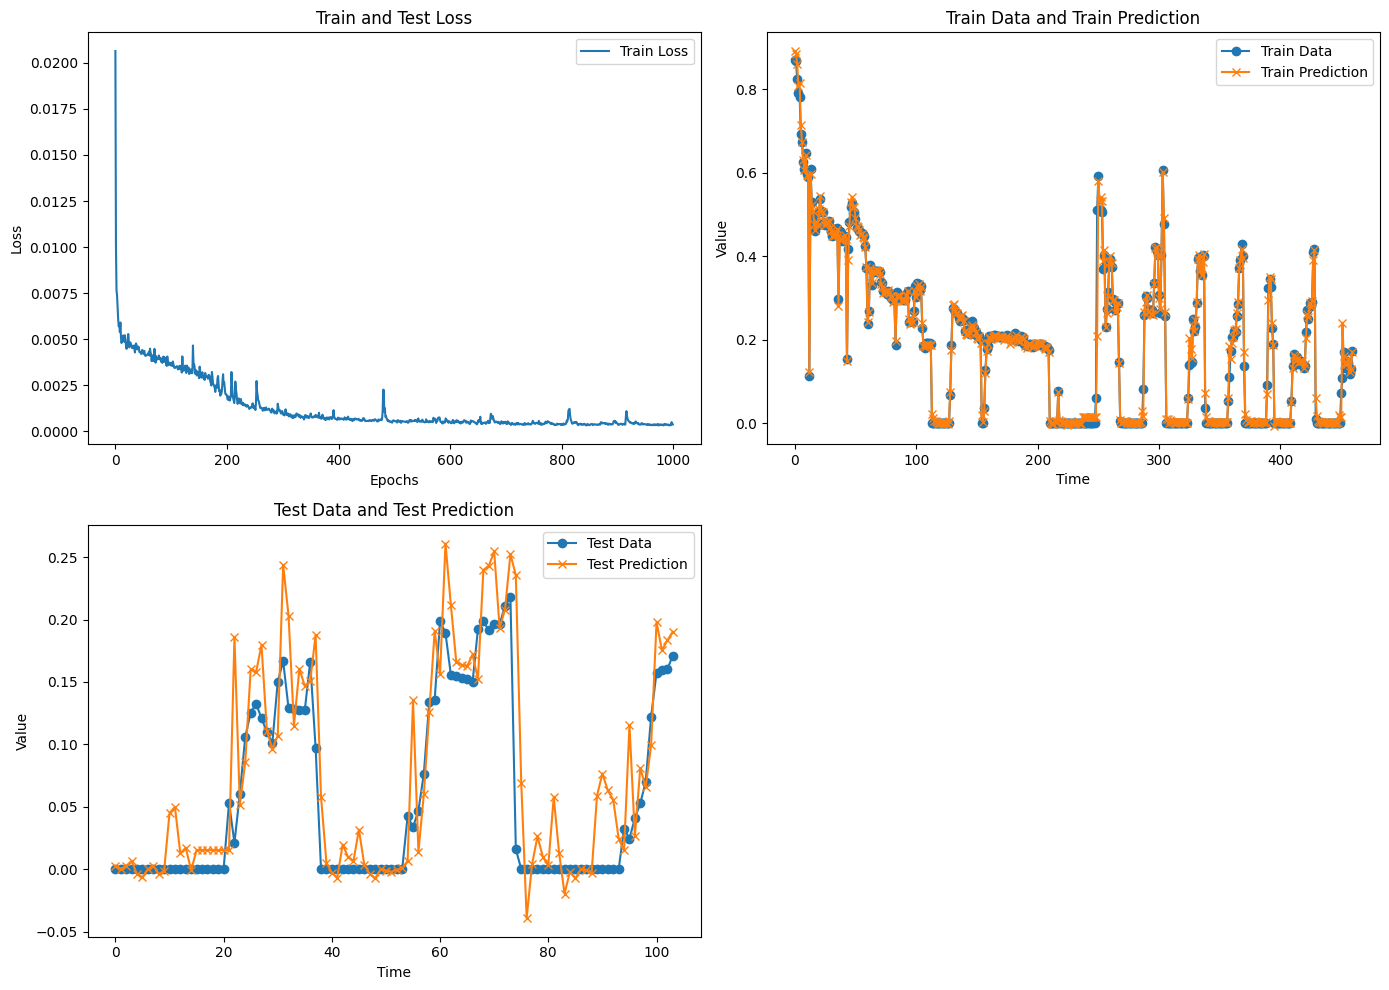

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

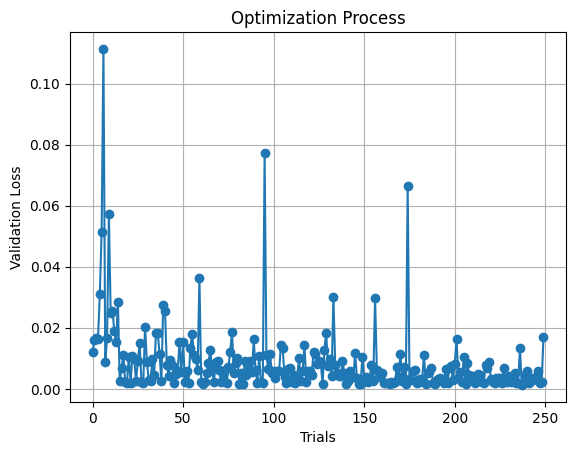

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

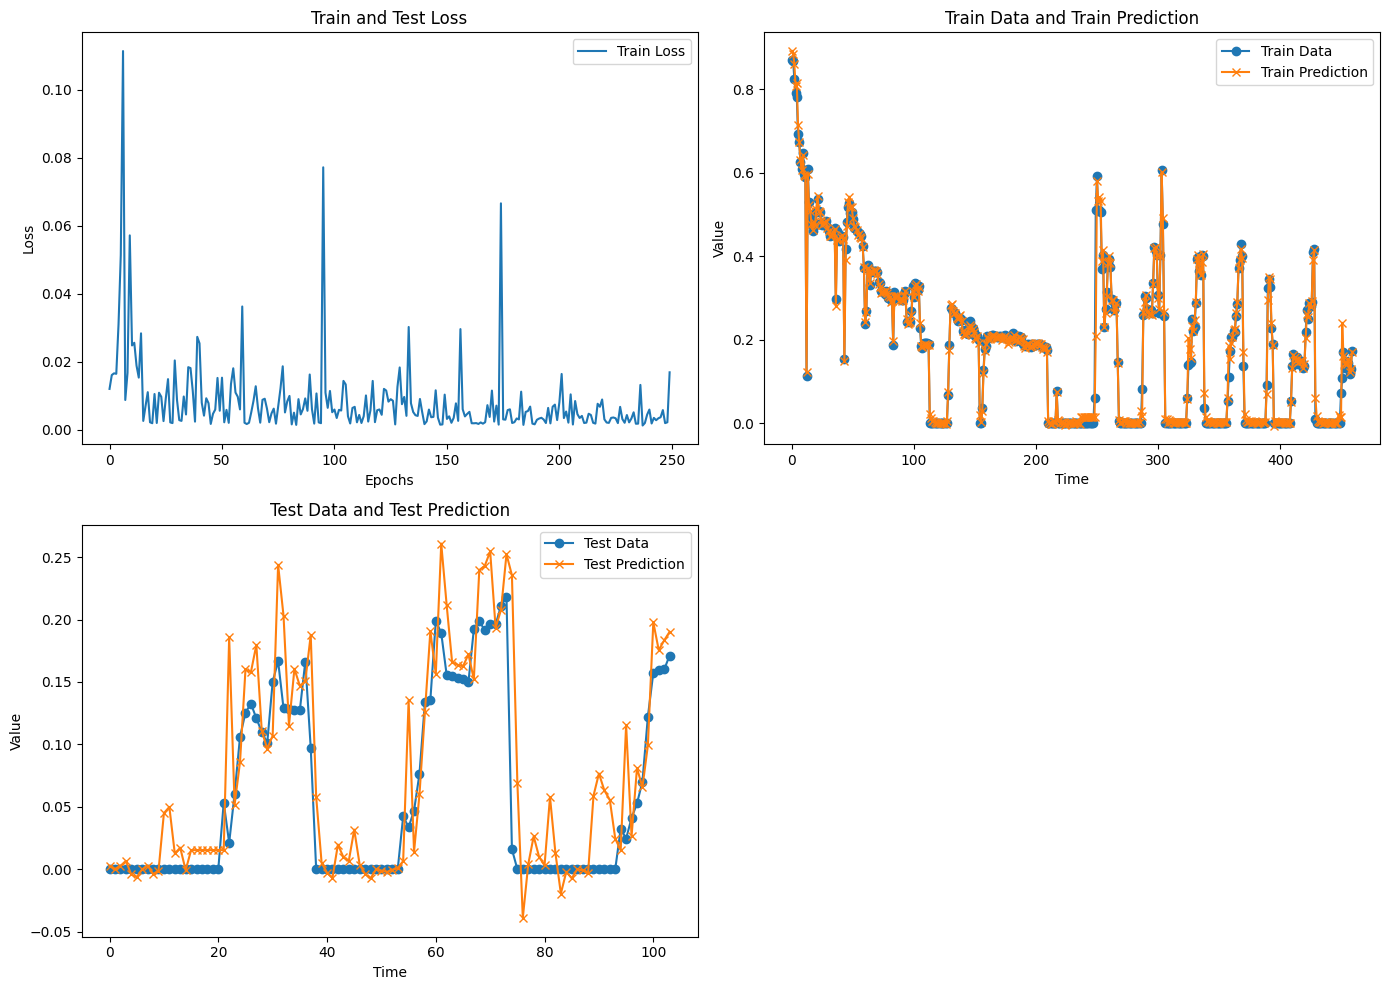

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.0063590269000138346
Test MSE: 0.0008544427496884458


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.000350  0.001886
1  Baseline   0.006359  0.000854


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 41, 'n_lstm_layers': 17, 'lstm_units': 237, 'learning_rate': 0.005370656799800972, 'Dropout_rate': 0.2650709578881727}
Trial 2: {'window_size': 40, 'n_lstm_layers': 5, 'lstm_units': 100, 'learning_rate': 0.000880039401559349, 'Dropout_rate': 0.34992480187675634}
Trial 3: {'window_size': 23, 'n_lstm_layers': 8, 'lstm_units': 207, 'learning_rate': 0.008345077380317305, 'Dropout_rate': 0.49727829715389893}
Trial 4: {'window_size': 40, 'n_lstm_layers': 12, 'lstm_units': 138, 'learning_rate': 0.003482379171892496, 'Dropout_rate': 0.48453893559243433}
Trial 5: {'window_size': 6, 'n_lstm_layers': 16, 'lstm_units': 48, 'learning_rate': 0.006911255354020627, 'Dropout_rate': 0.4194864919143445}
Trial 6: {'window_size': 11, 'n_lstm_layers': 12, 'lstm_units': 184, 'learning_rate': 0.005251860419435248, 'Dropout_rate': 0.40278114646762997}
Trial 7: {'window_size': 59, 'n_lstm_layers': 14, 'lstm_units': 204, 'learning_rate': 0.008059